## Import Libraries

In [41]:
import tensorflow as tf # type: ignore
from tensorflow.keras import layers, models, callbacks # type: ignore
import keras_tuner as kt # type: ignore

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Data Preparation

In [42]:
# Define dataset directories
train_dir = "../Dataset for CA1 part A - AY2526S1/train"
val_dir = "../Dataset for CA1 part A - AY2526S1/validation"
test_dir = "../Dataset for CA1 part A - AY2526S1/test"

In [43]:
# Create a function to load the dataset, convert it to grayscale and resize it to the target size
def load_dataset(data_dir, target_size):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=(224, 224),  # Load original size first
        batch_size=32,
        label_mode="int",  # or 'categorical' if needed
        shuffle=True,
    )

    # Convert RGB to grayscale and resize to target size
    def preprocess(image, label):
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.resize(image, target_size)
        return image, label

    dataset = dataset.map(preprocess)
    return dataset

In [44]:
# Create datasets for both sizes
train_23 = load_dataset(train_dir, (23,23))
val_23 = load_dataset(val_dir, (23,23))
test_23 = load_dataset(test_dir, (23,23))

train_101 = load_dataset(train_dir, (101,101))
val_101 = load_dataset(val_dir, (101,101))
test_101 = load_dataset(test_dir, (101,101))

Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.


In [45]:
# Load just the class names without processing images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

print("\nClasses detected by TensorFlow:")
print(train_ds.class_names)
print(test_ds.class_names)
print(val_ds.class_names)

Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.

Classes detected by TensorFlow:
['Bean', 'Bitter_Gourd', 'Bottle_Gourd and Cucumber', 'Brinjal', 'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish', 'Potato', 'Pumpkin', 'Tomato']
['Bean', 'Bitter_Gourd', 'Bottle_Gourd and Cucumber', 'Brinjal', 'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish', 'Potato', 'Pumpkin', 'Tomato']
['Bean', 'Bitter_Gourd', 'Bottle_Gourd and Cucumber', 'Brinjal', 'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish', 'Potato', 'Pumpkin', 'Tomato']


In [46]:
# Verify one sample from each
def inspect_dataset(dataset, name):
    for images, labels in dataset.take(1):
        print(f"\n{name} - Batch info:")
        print("Image shape:", images.shape)
        print("Label shape:", labels.shape)
        print("Pixel range:", (images.numpy().min(), images.numpy().max()))
        if hasattr(dataset, 'class_names'):
            print("Classes:", dataset.class_names)
        else:
            print("Class names not available in dataset object")

inspect_dataset(train_23, "Train 23x23")
inspect_dataset(val_101, "Validation 101x101")


Train 23x23 - Batch info:
Image shape: (32, 23, 23, 1)
Label shape: (32,)
Pixel range: (0.0, 254.97452)
Class names not available in dataset object

Validation 101x101 - Batch info:
Image shape: (32, 101, 101, 1)
Label shape: (32,)
Pixel range: (0.0, 254.97452)
Class names not available in dataset object


23x23 Samples:


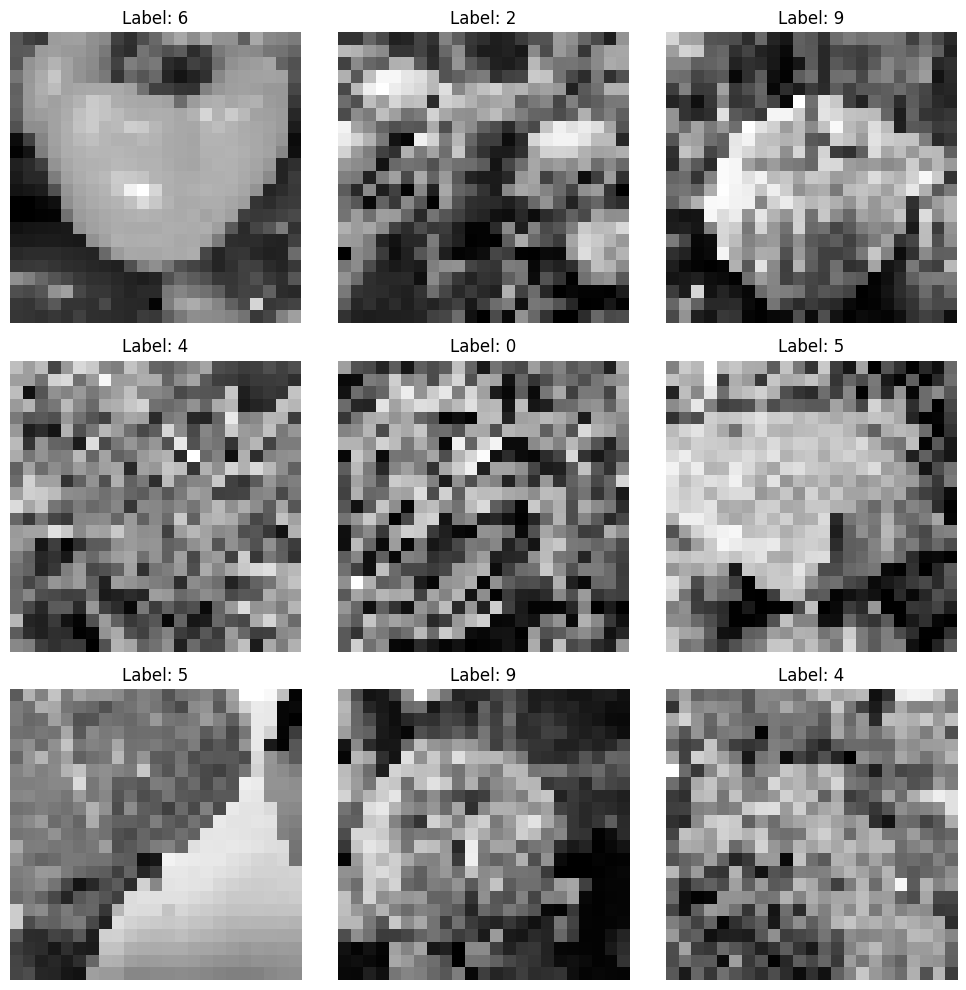


101x101 Samples:


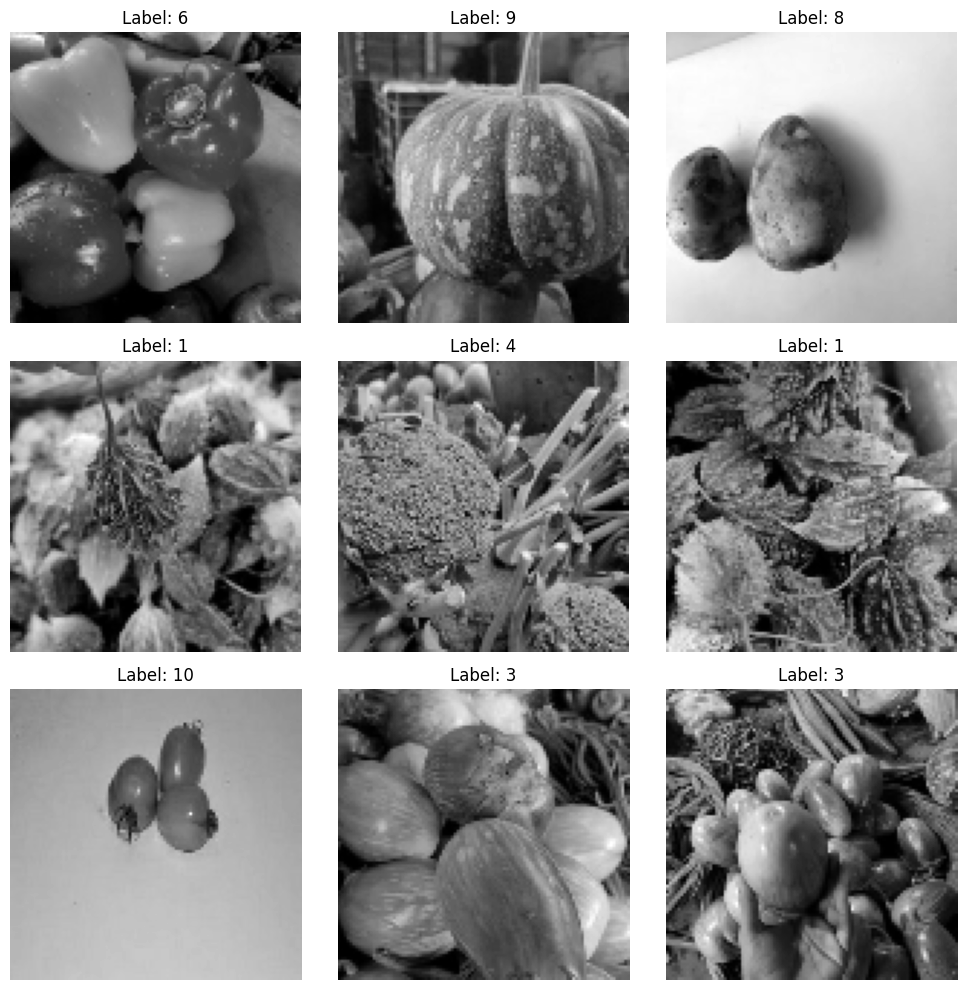

In [47]:
# View the first 9 samples of the training set
def show_samples(dataset, n=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(min(n, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap="gray")
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis("off")
    plt.tight_layout()
    plt.show()


print("23x23 Samples:")
show_samples(train_23)

print("\n101x101 Samples:")
show_samples(train_101)

In [48]:
# Load just the class names without processing images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

print("\nClasses detected by TensorFlow:")
print(train_ds.class_names)
print(test_ds.class_names)
print(val_ds.class_names)

Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.

Classes detected by TensorFlow:
['Bean', 'Bitter_Gourd', 'Bottle_Gourd and Cucumber', 'Brinjal', 'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish', 'Potato', 'Pumpkin', 'Tomato']
['Bean', 'Bitter_Gourd', 'Bottle_Gourd and Cucumber', 'Brinjal', 'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish', 'Potato', 'Pumpkin', 'Tomato']
['Bean', 'Bitter_Gourd', 'Bottle_Gourd and Cucumber', 'Brinjal', 'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish', 'Potato', 'Pumpkin', 'Tomato']


In [49]:
# Ensure preprocessing of the dataset was done correctly
def verify_preprocessing(dataset, expected_size):
    batch = next(iter(dataset.take(1)))
    images, _ = batch

    print("\nPreprocessing Verification:")
    print(f"Expected size: {expected_size}")
    print(f"Actual size: {images.shape[1:3]}")
    print(f"Channels: {images.shape[-1]} (1=grayscale)")
    print("Normalization check:")
    print(f"Min: {tf.reduce_min(images):.4f}, Max: {tf.reduce_max(images):.4f}")


verify_preprocessing(train_23, (23, 23))
verify_preprocessing(train_101, (101, 101))


Preprocessing Verification:
Expected size: (23, 23)
Actual size: (23, 23)
Channels: 1 (1=grayscale)
Normalization check:
Min: 0.0000, Max: 253.7831

Preprocessing Verification:
Expected size: (101, 101)
Actual size: (101, 101)
Channels: 1 (1=grayscale)
Normalization check:
Min: 0.0000, Max: 254.7072


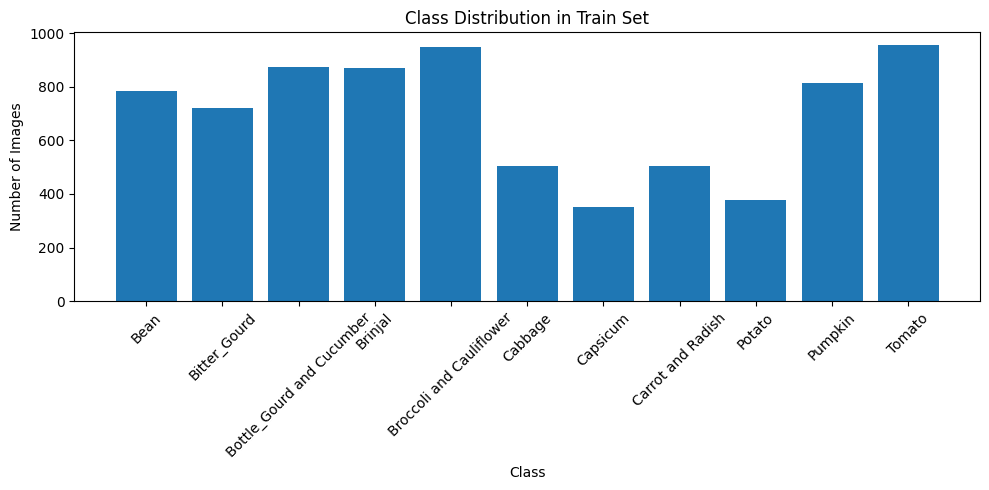

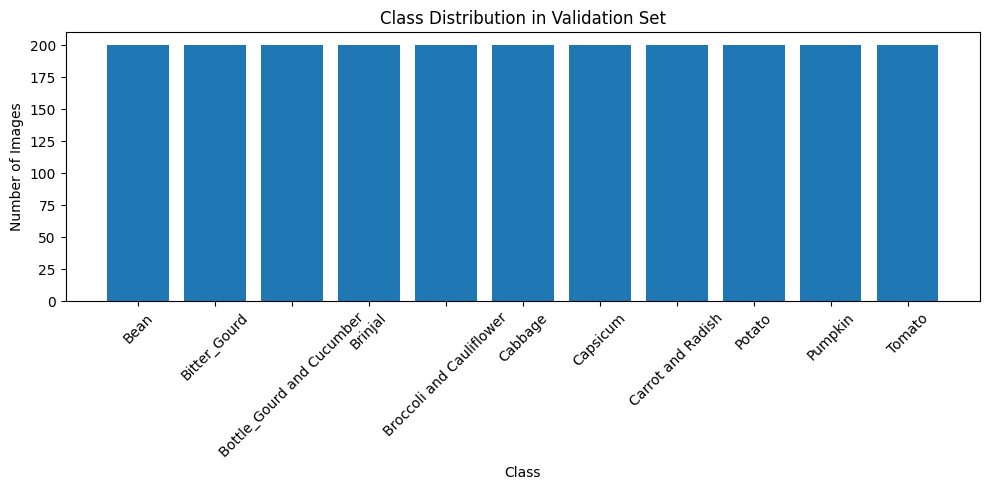

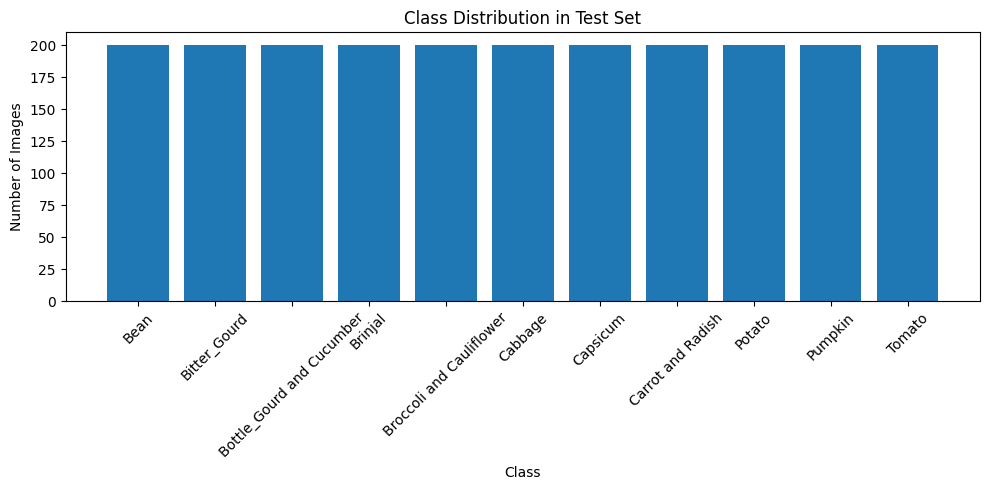

In [50]:
import os
import collections

# Plot class distribution for train, validation, and test sets

def plot_class_distribution(data_dir, set_name):

  class_counts = collections.Counter()
  for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
      count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
      class_counts[class_name] = count

  plt.figure(figsize=(10, 5))
  plt.bar(class_counts.keys(), class_counts.values())
  plt.title(f'Class Distribution in {set_name} Set')
  plt.xlabel('Class')
  plt.ylabel('Number of Images')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

plot_class_distribution(train_dir, "Train")
plot_class_distribution(val_dir, "Validation")
plot_class_distribution(test_dir, "Test")

## Fully Connected Model (Baseline)

In [51]:
# Function to create a simple fully connected model (baseline)
def create_fc_baseline_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),  # Flatten input to 1D
        layers.Dense(128, activation='relu'),     # Hidden layer with 128 neurons
        layers.Dropout(0.5),                      # Dropout layer to prevent overfitting
        layers.Dense(64, activation='relu'),      # Another hidden layer with 64 neurons
        layers.Dropout(0.5),                      # Dropout to prevent overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer with 'softmax' activation
    ])
    
    # Compile the model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Function to train the FC model and plot the training history
def train_fc_baseline_model(input_shape, num_classes, train_ds, val_ds, test_ds, model_name, epochs=50):
    # Create the model
    model = create_fc_baseline_model(input_shape, num_classes)
    
    # Train the model
    history = model.fit(
        train_ds,  # Training dataset
        validation_data=val_ds,  # Validation dataset
        epochs=epochs,  # Number of epochs
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],  # Early stopping to prevent overfitting
        verbose=1
    )
    
    # Plotting Training History
    plt.figure(figsize=(12, 4))
    
    # Plotting Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.legend()
    
    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Evaluate on the test dataset
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"{model_name} - Test Accuracy: {test_acc:.4f}")
    print(f"{model_name} - Test Loss: {test_loss:.4f}")

    return model


Training 23x23 Model (Baseline)...
Epoch 1/50
241/241 [==============================] - 2s 9ms/step - loss: 11.1545 - accuracy: 0.1114 - val_loss: 2.4027 - val_accuracy: 0.0914
Epoch 2/50
241/241 [==============================] - 2s 8ms/step - loss: 2.3706 - accuracy: 0.1157 - val_loss: 2.4122 - val_accuracy: 0.0914
Epoch 3/50
241/241 [==============================] - 2s 8ms/step - loss: 2.3564 - accuracy: 0.1233 - val_loss: 2.4221 - val_accuracy: 0.0914
Epoch 4/50
241/241 [==============================] - 2s 8ms/step - loss: 2.3539 - accuracy: 0.1277 - val_loss: 2.4302 - val_accuracy: 0.0914
Epoch 5/50
241/241 [==============================] - 2s 8ms/step - loss: 2.3499 - accuracy: 0.1190 - val_loss: 2.4367 - val_accuracy: 0.0914
Epoch 6/50
241/241 [==============================] - 2s 8ms/step - loss: 2.3485 - accuracy: 0.1287 - val_loss: 2.4415 - val_accuracy: 0.0914


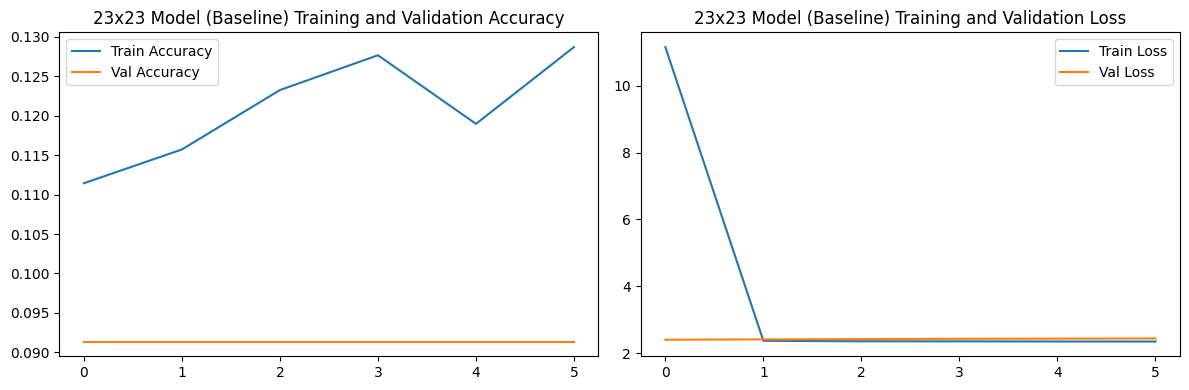

69/69 [==============================] - 0s 6ms/step - loss: 2.4431 - accuracy: 0.0909
23x23 Model (Baseline) - Test Accuracy: 0.0909
23x23 Model (Baseline) - Test Loss: 2.4431

Training 101x101 Model (Baseline)...
Epoch 1/50
241/241 [==============================] - 2s 8ms/step - loss: 40.9249 - accuracy: 0.1234 - val_loss: 2.4046 - val_accuracy: 0.0909
Epoch 2/50
241/241 [==============================] - 2s 8ms/step - loss: 2.3630 - accuracy: 0.1191 - val_loss: 2.4167 - val_accuracy: 0.0909
Epoch 3/50
241/241 [==============================] - 2s 9ms/step - loss: 2.3554 - accuracy: 0.1231 - val_loss: 2.4267 - val_accuracy: 0.0909
Epoch 4/50
241/241 [==============================] - 2s 9ms/step - loss: 2.3522 - accuracy: 0.1179 - val_loss: 2.4341 - val_accuracy: 0.0909
Epoch 5/50
241/241 [==============================] - 2s 8ms/step - loss: 2.3504 - accuracy: 0.1234 - val_loss: 2.4393 - val_accuracy: 0.0909
Epoch 6/50
241/241 [==============================] - 2s 8ms/step - loss: 

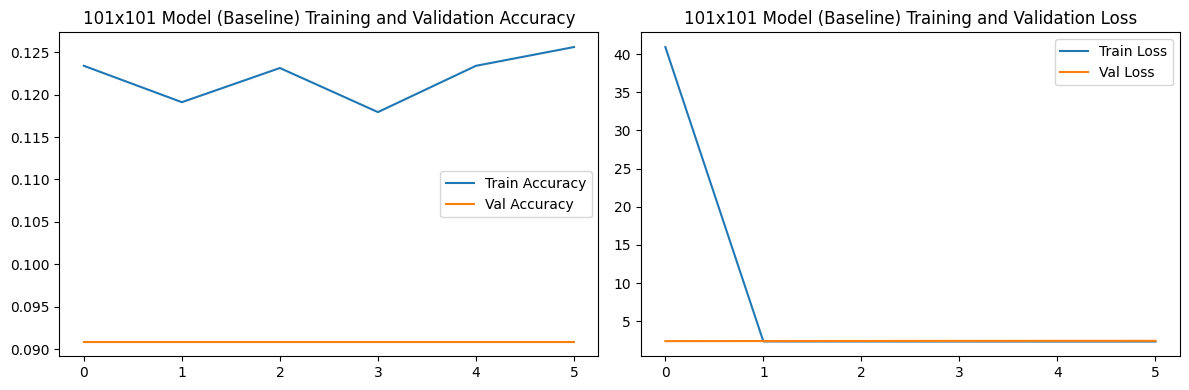

69/69 [==============================] - 1s 6ms/step - loss: 2.4435 - accuracy: 0.0909
101x101 Model (Baseline) - Test Accuracy: 0.0909
101x101 Model (Baseline) - Test Loss: 2.4435


In [52]:
# 23x23 Model (Baseline)
print("\nTraining 23x23 Model (Baseline)...")
input_shape_23 = (23, 23, 1)  # For grayscale images of size 23x23 pixels
num_classes = 11  # 11 classes for classification (vegetables)
fc_baseline_model_23 = train_fc_baseline_model(input_shape_23, num_classes, train_23, val_23, test_23, "23x23 Model (Baseline)")

# 101x101 Model (Baseline)
print("\nTraining 101x101 Model (Baseline)...")
input_shape_101 = (101, 101, 1)  # For grayscale images of size 101x101 pixels
fc_baseline_model_101 = train_fc_baseline_model(input_shape_101, num_classes, train_101, val_101, test_101, "101x101 Model (Baseline)")

1/1 [==============================] - 0s 36ms/step


<Figure size 800x600 with 0 Axes>

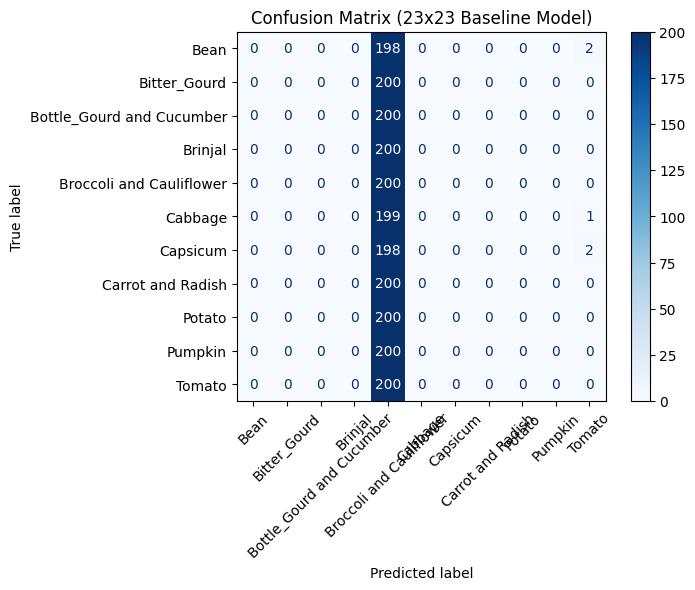

In [53]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_23:
  preds = fc_baseline_model_23.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (23x23 Baseline Model)")
plt.show()

## Training CNN Models

In [54]:
# Create Function to Create the Model with the Following Layers by Passing in the Input Shape
def create_model(input_shape):
    model = models.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation="relu"),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation="relu"),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(11, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [55]:
# Define Function to train the CNN Model
def train_model(model, train_ds, val_ds, model_name):
    early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=[early_stopping],
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{model_name} Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}_training.png")
    plt.show()

    return model

Training 23x23 model...
Epoch 1/50
241/241 [==============================] - 3s 11ms/step - loss: 2.5316 - accuracy: 0.1844 - val_loss: 2.1795 - val_accuracy: 0.2336
Epoch 2/50
241/241 [==============================] - 2s 10ms/step - loss: 1.9734 - accuracy: 0.3169 - val_loss: 1.9214 - val_accuracy: 0.3209
Epoch 3/50
241/241 [==============================] - 3s 11ms/step - loss: 1.6955 - accuracy: 0.4193 - val_loss: 1.6176 - val_accuracy: 0.4518
Epoch 4/50
241/241 [==============================] - 3s 11ms/step - loss: 1.4961 - accuracy: 0.4945 - val_loss: 1.5926 - val_accuracy: 0.4673
Epoch 5/50
241/241 [==============================] - 3s 11ms/step - loss: 1.3125 - accuracy: 0.5573 - val_loss: 1.3643 - val_accuracy: 0.5364
Epoch 6/50
241/241 [==============================] - 3s 11ms/step - loss: 1.1531 - accuracy: 0.6133 - val_loss: 1.3404 - val_accuracy: 0.5586
Epoch 7/50
241/241 [==============================] - 3s 10ms/step - loss: 1.0329 - accuracy: 0.6554 - val_loss: 1.156

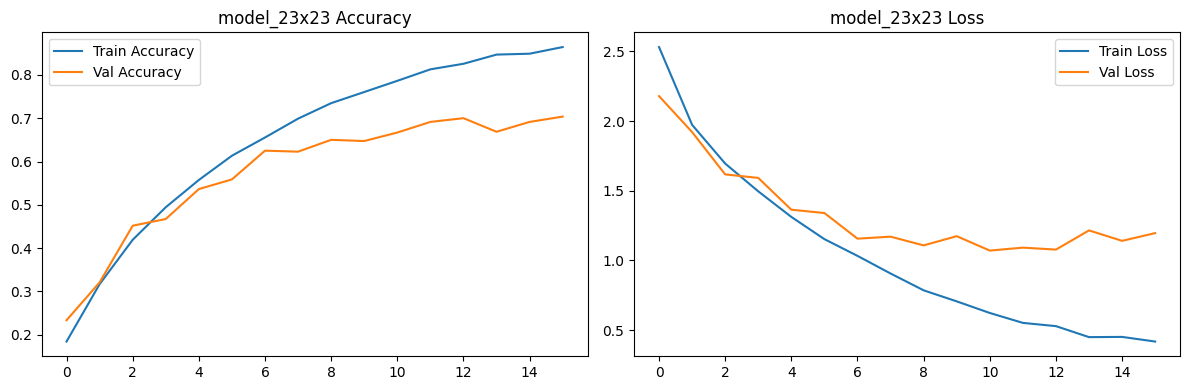

In [56]:
# Train the Models for the 2 different Input Sizes
print("Training 23x23 model...")
model_23 = create_model((23, 23, 1))
train_model(model_23, train_23, val_23, "model_23x23")

1/1 [==============================] - 0s 50ms/step


<Figure size 800x600 with 0 Axes>

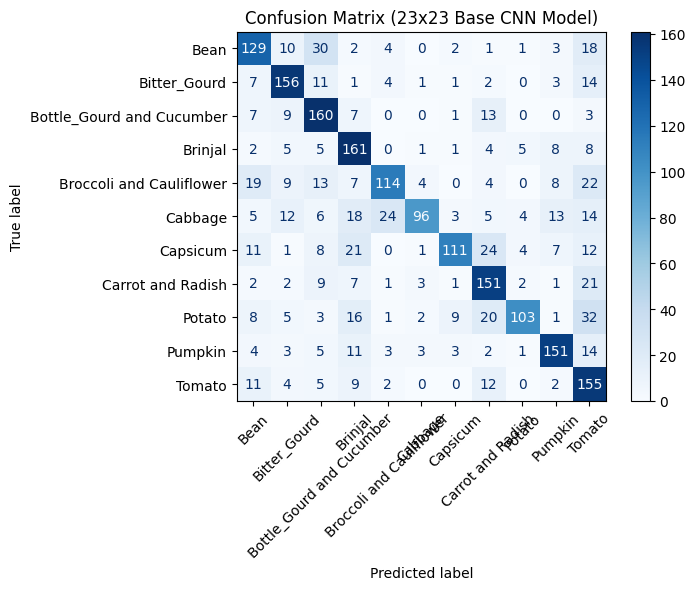

In [57]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_23:
  preds = model_23.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (23x23 Base CNN Model)")
plt.show()


Training 101x101 model...
Epoch 1/50
241/241 [==============================] - 4s 16ms/step - loss: 6.4397 - accuracy: 0.1735 - val_loss: 2.2400 - val_accuracy: 0.2623
Epoch 2/50
241/241 [==============================] - 4s 14ms/step - loss: 2.0823 - accuracy: 0.3085 - val_loss: 1.9461 - val_accuracy: 0.3650
Epoch 3/50
241/241 [==============================] - 4s 15ms/step - loss: 1.9422 - accuracy: 0.3624 - val_loss: 1.8043 - val_accuracy: 0.4209
Epoch 4/50
241/241 [==============================] - 4s 17ms/step - loss: 1.5793 - accuracy: 0.4747 - val_loss: 1.7738 - val_accuracy: 0.4523
Epoch 5/50
241/241 [==============================] - 4s 16ms/step - loss: 1.2975 - accuracy: 0.5675 - val_loss: 1.7237 - val_accuracy: 0.4782
Epoch 6/50
241/241 [==============================] - 4s 15ms/step - loss: 1.0780 - accuracy: 0.6435 - val_loss: 1.7984 - val_accuracy: 0.4859
Epoch 7/50
241/241 [==============================] - 4s 16ms/step - loss: 0.9398 - accuracy: 0.6815 - val_loss: 1.

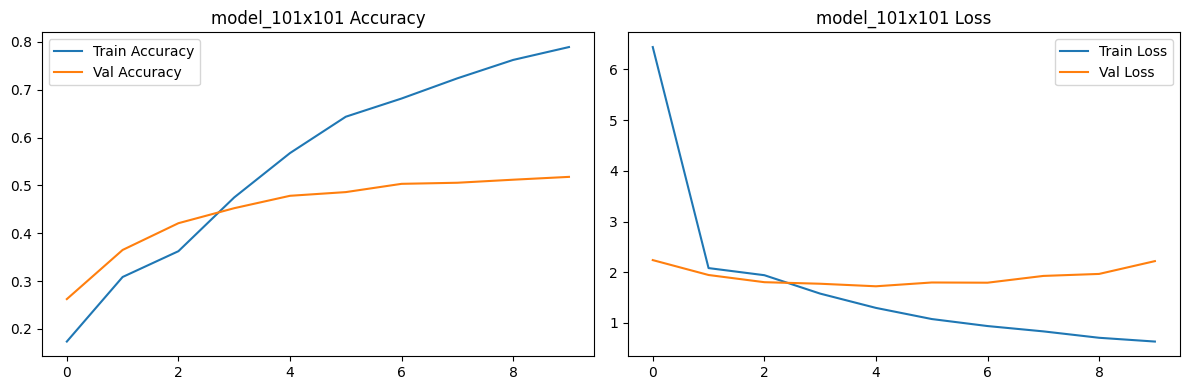

In [58]:
print("\nTraining 101x101 model...")
model_101 = create_model((101, 101, 1))
train_model(model_101, train_101, val_101, "model_101x101")

1/1 [==============================] - 0s 68ms/step


<Figure size 800x600 with 0 Axes>

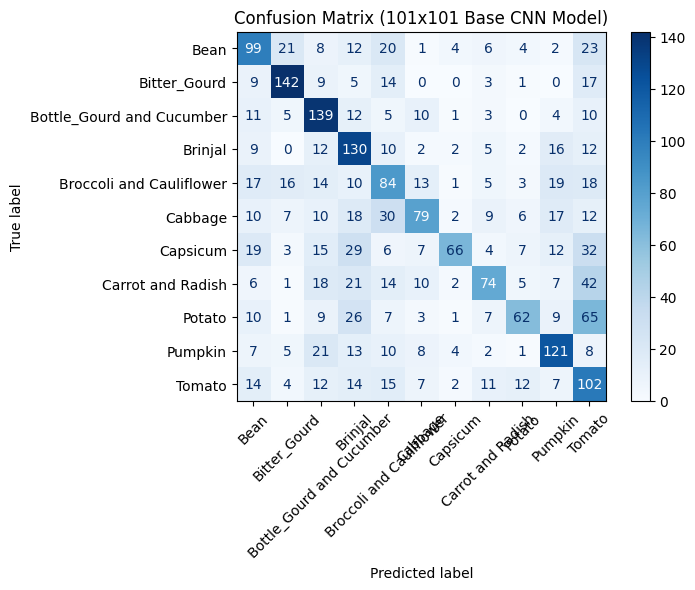

In [59]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_101:
  preds = model_101.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (101x101 Base CNN Model)")
plt.show()

In [60]:
# Evaluate the model's Performance using the Test Dataset
# Evaluation with basic metrics
def evaluate_model_basic(model, test_ds, model_name):
    print(f"\nEvaluating {model_name}:")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1-accuracy):.4f}")
    return loss, accuracy

# Get metrics for comparison
loss_23, acc_23 = evaluate_model_basic(model_23, test_23, "23x23 Model")
loss_101, acc_101 = evaluate_model_basic(model_101, test_101, "101x101 Model")

print(f"\nAccuracy Improvement: {(acc_101-acc_23):.4f}")
print(f"Loss Reduction: {(loss_23-loss_101):.4f}")


Evaluating 23x23 Model:
Test Loss: 1.2631
Test Accuracy: 0.6759
Error Rate: 0.3241

Evaluating 101x101 Model:
Test Loss: 2.2382
Test Accuracy: 0.4991
Error Rate: 0.5009

Accuracy Improvement: -0.1768
Loss Reduction: -0.9750


## Improving the CNN Models

In [61]:
# Define the improved model architecture
def create_improved_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(11, activation='softmax'),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [62]:
# Train the improved model
def train_improved_model(model, train_ds, val_ds, model_name, epochs=50):
    print(f"\nTraining {model_name} (Improved) model...")

    early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{model_name} Accuracy (Improved)")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{model_name} Loss (Improved)")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}_training_improved.png")
    plt.show()

    return model


Training model_23x23 (Improved) model...
Epoch 1/50
241/241 [==============================] - 4s 14ms/step - loss: 1.8339 - accuracy: 0.3820 - val_loss: 1.7698 - val_accuracy: 0.3714
Epoch 2/50
241/241 [==============================] - 3s 13ms/step - loss: 1.2811 - accuracy: 0.5775 - val_loss: 1.2579 - val_accuracy: 0.5900
Epoch 3/50
241/241 [==============================] - 3s 13ms/step - loss: 0.9738 - accuracy: 0.6845 - val_loss: 1.0171 - val_accuracy: 0.6532
Epoch 4/50
241/241 [==============================] - 3s 14ms/step - loss: 0.7684 - accuracy: 0.7474 - val_loss: 0.9564 - val_accuracy: 0.6923
Epoch 5/50
241/241 [==============================] - 3s 13ms/step - loss: 0.6471 - accuracy: 0.7839 - val_loss: 0.8384 - val_accuracy: 0.7214
Epoch 6/50
241/241 [==============================] - 3s 13ms/step - loss: 0.5565 - accuracy: 0.8178 - val_loss: 1.0427 - val_accuracy: 0.6768
Epoch 7/50
241/241 [==============================] - 3s 13ms/step - loss: 0.4535 - accuracy: 0.8502

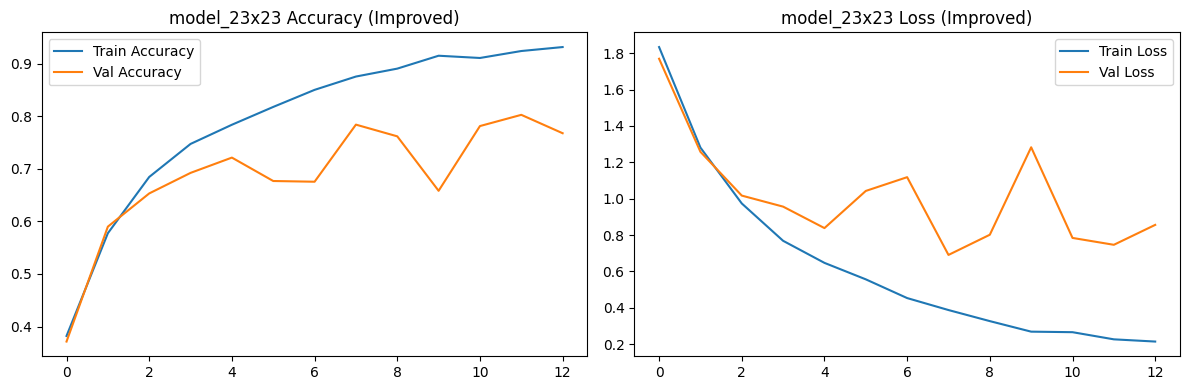


Training model_101x101 (Improved) model...
Epoch 1/50
241/241 [==============================] - 5s 20ms/step - loss: 1.6345 - accuracy: 0.4507 - val_loss: 1.6114 - val_accuracy: 0.3950
Epoch 2/50
241/241 [==============================] - 5s 19ms/step - loss: 1.0249 - accuracy: 0.6627 - val_loss: 3.2248 - val_accuracy: 0.2336
Epoch 3/50
241/241 [==============================] - 5s 19ms/step - loss: 0.7362 - accuracy: 0.7630 - val_loss: 3.1147 - val_accuracy: 0.3314
Epoch 4/50
241/241 [==============================] - 5s 19ms/step - loss: 0.5718 - accuracy: 0.8147 - val_loss: 3.2485 - val_accuracy: 0.4595
Epoch 5/50
241/241 [==============================] - 5s 19ms/step - loss: 0.4627 - accuracy: 0.8574 - val_loss: 1.7793 - val_accuracy: 0.4832
Epoch 6/50
241/241 [==============================] - 5s 20ms/step - loss: 0.3578 - accuracy: 0.8889 - val_loss: 2.7261 - val_accuracy: 0.5127


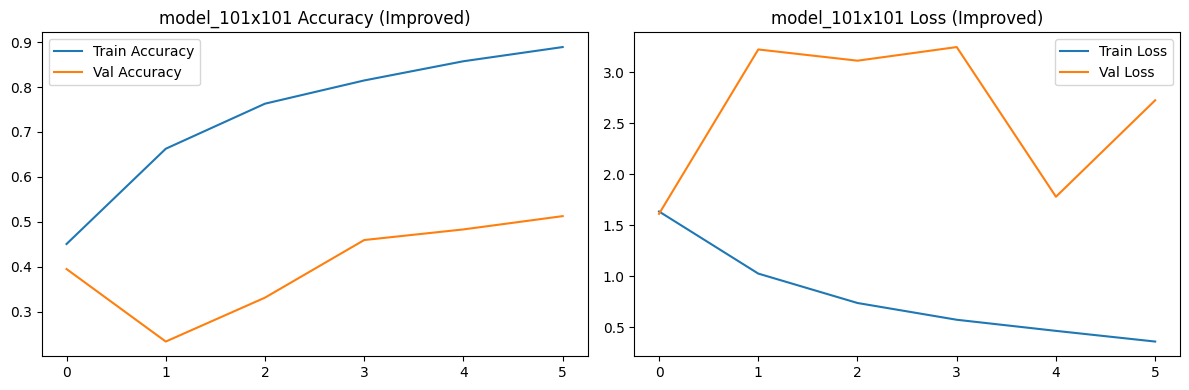

In [63]:
# Create improved models
improved_model_23 = create_improved_model((23, 23, 1))
improved_model_101 = create_improved_model((101, 101, 1))

# Train improved models
improved_model_23 = train_improved_model(improved_model_23, train_23, val_23, "model_23x23")
improved_model_101 = train_improved_model(improved_model_101, train_101, val_101, "model_101x101")

1/1 [==============================] - 0s 66ms/step


<Figure size 800x600 with 0 Axes>

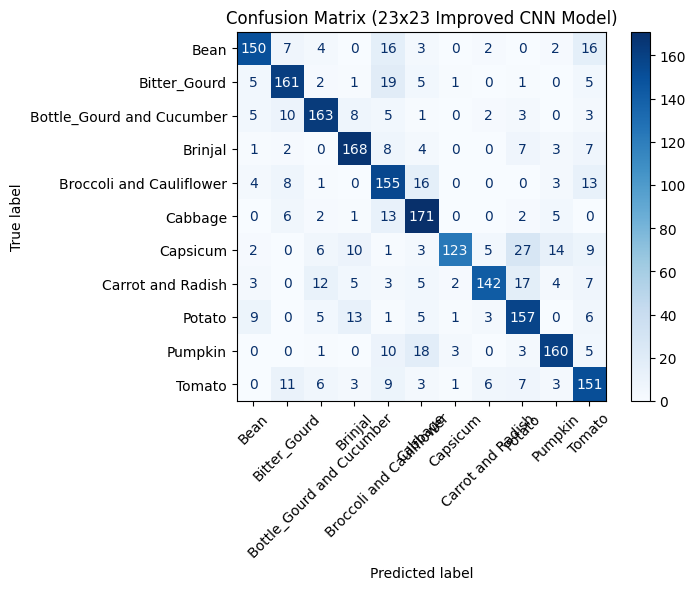

In [64]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_23:
  preds = improved_model_23.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (23x23 Improved CNN Model)")
plt.show()

1/1 [==============================] - 0s 16ms/step


<Figure size 800x600 with 0 Axes>

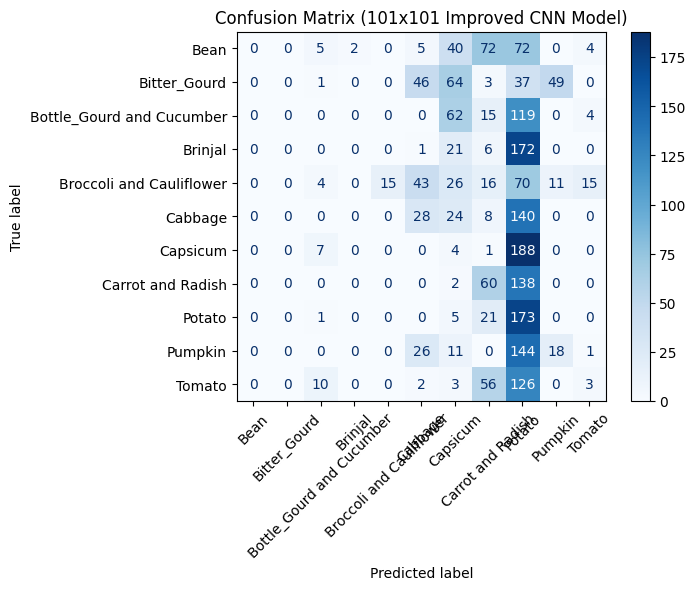

In [65]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_101:
  preds = improved_model_23.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (101x101 Improved CNN Model)")
plt.show()

In [66]:
# Evaluate the improved model's performance using the test dataset
def evaluate_model_basic_improved(model, test_ds, model_name):
    print(f"\nEvaluating {model_name} (Improved):")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1 - accuracy):.4f}")
    return loss, accuracy

# Evaluate improved models
loss_23_improved, acc_23_improved = evaluate_model_basic_improved(improved_model_23, test_23, "23x23 Model")
loss_101_improved, acc_101_improved = evaluate_model_basic_improved(improved_model_101, test_101, "101x101 Model")

# Comparison between improved models
print(f"\nAccuracy Improvement (101x101 - 23x23): {(acc_101_improved - acc_23_improved):.4f}")
print(f"Loss Reduction (23x23 - 101x101): {(loss_23_improved - loss_101_improved):.4f}")


Evaluating 23x23 Model (Improved):
Test Loss: 0.6927
Test Accuracy: 0.7732
Error Rate: 0.2268

Evaluating 101x101 Model (Improved):
Test Loss: 1.5868
Test Accuracy: 0.4077
Error Rate: 0.5923

Accuracy Improvement (101x101 - 23x23): -0.3655
Loss Reduction (23x23 - 101x101): -0.8942


## Implement Hyperparameter Tuning for the 23x23 Model

In [67]:
# Define the model-building function for Keras Tuner
def build_23_model_with_hyperparameters(hp):
    tuned_23_model = models.Sequential()
    
    # Conv Layer 1
    tuned_23_model.add(layers.Conv2D(
        hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        (3, 3), activation='relu', input_shape=(23, 23, 1)
    ))
    tuned_23_model.add(layers.BatchNormalization())
    tuned_23_model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 2
    tuned_23_model.add(layers.Conv2D(
        hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
        (3, 3), activation='relu'
    ))
    tuned_23_model.add(layers.BatchNormalization())
    tuned_23_model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 3
    tuned_23_model.add(layers.Conv2D(
        hp.Int('conv_3_filters', min_value=128, max_value=512, step=128),
        (3, 3), activation='relu'
    ))
    tuned_23_model.add(layers.BatchNormalization())
    
    tuned_23_model.add(layers.GlobalAveragePooling2D())
    
    # Dense Layer
    tuned_23_model.add(layers.Dense(
        hp.Int('dense_units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))
    tuned_23_model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)))
    
    # Output Layer
    tuned_23_model.add(layers.Dense(11, activation='softmax'))

    # Compile the model
    tuned_23_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return tuned_23_model

# Set up Keras Tuner with Random Search
tuner = kt.RandomSearch(
    build_23_model_with_hyperparameters,
    objective='val_accuracy',
    max_trials=50,
    directory='kt_dir',
    project_name='improved_23_model_tuning'
)

Reloading Tuner from kt_dir\improved_23_model_tuning\tuner0.json


In [68]:
# Run hyperparameter tuning
tuner.search(
    train_23,  # Training dataset
    validation_data=val_23,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

Best Hyperparameters: {'conv_1_filters': 64, 'conv_2_filters': 192, 'conv_3_filters': 384, 'dense_units': 384, 'dropout_rate': 0.5, 'learning_rate': 0.00028745791047186465}


In [69]:
# Build and train the model with the best hyperparameters
tuned_23_model = tuner.hypermodel.build(best_hps)
history = tuned_23_model.fit(
    train_23,  # Training dataset
    validation_data=val_23,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)

Epoch 1/50
241/241 [==============================] - 4s 14ms/step - loss: 1.6728 - accuracy: 0.4445 - val_loss: 1.5233 - val_accuracy: 0.4786
Epoch 2/50
241/241 [==============================] - 4s 15ms/step - loss: 1.0506 - accuracy: 0.6576 - val_loss: 0.9838 - val_accuracy: 0.6727
Epoch 3/50
241/241 [==============================] - 3s 13ms/step - loss: 0.6840 - accuracy: 0.7862 - val_loss: 0.7936 - val_accuracy: 0.7455
Epoch 4/50
241/241 [==============================] - 3s 13ms/step - loss: 0.4524 - accuracy: 0.8617 - val_loss: 0.7049 - val_accuracy: 0.7614
Epoch 5/50
241/241 [==============================] - 3s 13ms/step - loss: 0.3105 - accuracy: 0.9070 - val_loss: 0.7255 - val_accuracy: 0.7723
Epoch 6/50
241/241 [==============================] - 3s 12ms/step - loss: 0.2122 - accuracy: 0.9427 - val_loss: 0.8160 - val_accuracy: 0.7468
Epoch 7/50
241/241 [==============================] - 3s 13ms/step - loss: 0.1634 - accuracy: 0.9510 - val_loss: 0.6582 - val_accuracy: 0.8005

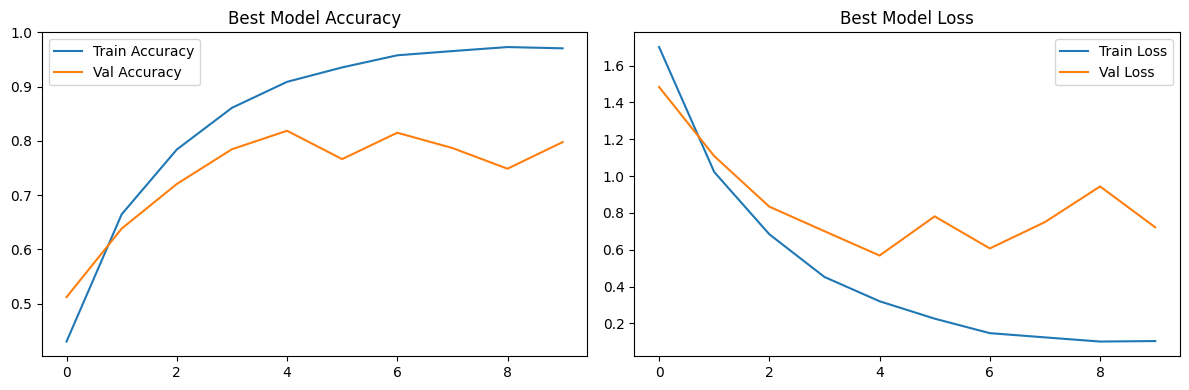

In [62]:
# Plotting Accuracy and Loss
plt.figure(figsize=(12, 4))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Best Model Accuracy")
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Best Model Loss")
plt.legend()

plt.tight_layout()
plt.savefig("tuned_23_model.png")
plt.show()

1/1 [==============================] - 0s 66ms/step


<Figure size 800x600 with 0 Axes>

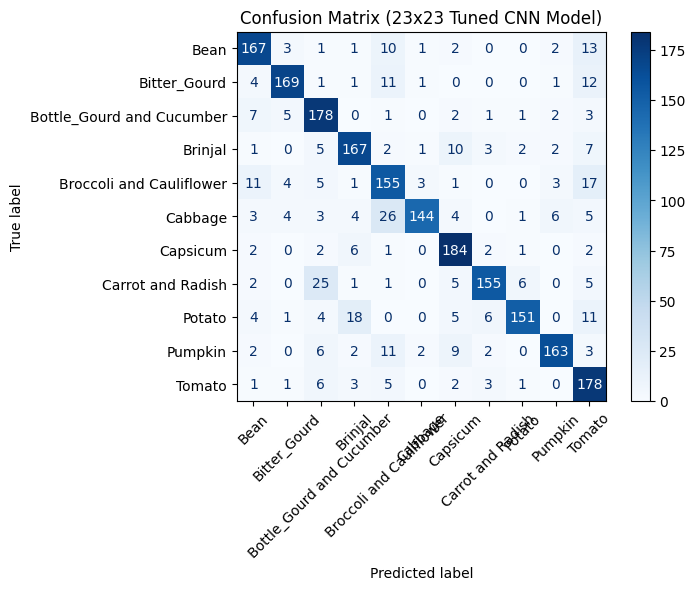

In [71]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_23:
  preds = tuned_23_model.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (23x23 Tuned CNN Model)")
plt.show()

In [70]:
# Evaluate the best model
test_loss, test_acc = tuned_23_model.evaluate(test_23)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

69/69 [==============================] - 1s 9ms/step - loss: 0.6464 - accuracy: 0.8232
Test Accuracy: 0.8232
Test Loss: 0.6464


## Implement Hyperparameter Tuning for the 101x101 Model

In [72]:
# Define the model-building function for Keras Tuner
def build_101_model_with_hyperparameters(hp):
    tuned_101_model = models.Sequential()
    
    # Conv Layer 1
    tuned_101_model.add(layers.Conv2D(
        hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        (3, 3), activation='relu', input_shape=(101, 101, 1)
    ))
    tuned_101_model.add(layers.BatchNormalization())
    tuned_101_model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 2
    tuned_101_model.add(layers.Conv2D(
        hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
        (3, 3), activation='relu'
    ))
    tuned_101_model.add(layers.BatchNormalization())
    tuned_101_model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 3
    tuned_101_model.add(layers.Conv2D(
        hp.Int('conv_3_filters', min_value=128, max_value=512, step=128),
        (3, 3), activation='relu'
    ))
    tuned_101_model.add(layers.BatchNormalization())
    
    tuned_101_model.add(layers.GlobalAveragePooling2D())
    
    # Dense Layer
    tuned_101_model.add(layers.Dense(
        hp.Int('dense_units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))
    tuned_101_model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)))
    
    # Output Layer
    tuned_101_model.add(layers.Dense(11, activation='softmax'))

    # Compile the model
    tuned_101_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return tuned_101_model

# Set up Keras Tuner with Random Search
tuner = kt.RandomSearch(
    build_101_model_with_hyperparameters,
    objective='val_accuracy',
    max_trials=50,
    directory='kt_dir',
    project_name='improved_101_model_tuning'
)

Reloading Tuner from kt_dir\improved_101_model_tuning\tuner0.json


In [73]:
# Run hyperparameter tuning
tuner.search(
    train_101,  # Training dataset
    validation_data=val_101,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

Best Hyperparameters: {'conv_1_filters': 96, 'conv_2_filters': 256, 'conv_3_filters': 384, 'dense_units': 384, 'dropout_rate': 0.4, 'learning_rate': 2.6233713088320727e-05}


In [74]:
# Build and train the model with the best hyperparameters
tuned_101_model = tuner.hypermodel.build(best_hps)
history = tuned_101_model.fit(
    train_101,  # Training dataset
    validation_data=val_101,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)

Epoch 1/50
241/241 [==============================] - 18s 67ms/step - loss: 1.8782 - accuracy: 0.3834 - val_loss: 1.8012 - val_accuracy: 0.3936
Epoch 2/50
241/241 [==============================] - 14s 58ms/step - loss: 1.4686 - accuracy: 0.5458 - val_loss: 1.4040 - val_accuracy: 0.5541
Epoch 3/50
241/241 [==============================] - 14s 58ms/step - loss: 1.2522 - accuracy: 0.6146 - val_loss: 1.2283 - val_accuracy: 0.6045
Epoch 4/50
241/241 [==============================] - 14s 58ms/step - loss: 1.1089 - accuracy: 0.6641 - val_loss: 1.0606 - val_accuracy: 0.6759
Epoch 5/50
241/241 [==============================] - 14s 58ms/step - loss: 0.9891 - accuracy: 0.7063 - val_loss: 0.9660 - val_accuracy: 0.7009
Epoch 6/50
241/241 [==============================] - 14s 58ms/step - loss: 0.8945 - accuracy: 0.7401 - val_loss: 0.8101 - val_accuracy: 0.7750
Epoch 7/50
241/241 [==============================] - 14s 59ms/step - loss: 0.8116 - accuracy: 0.7589 - val_loss: 0.7157 - val_accuracy:

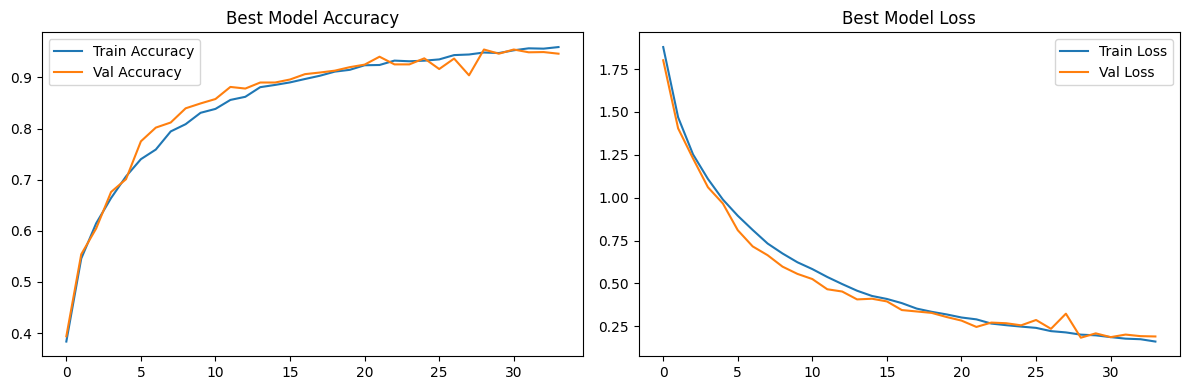

In [75]:
# Plotting Accuracy and Loss
plt.figure(figsize=(12, 4))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Best Model Accuracy")
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Best Model Loss")
plt.legend()

plt.tight_layout()
plt.savefig("tuned_101_model.png")
plt.show()

1/1 [==============================] - 0s 68ms/step


<Figure size 800x600 with 0 Axes>

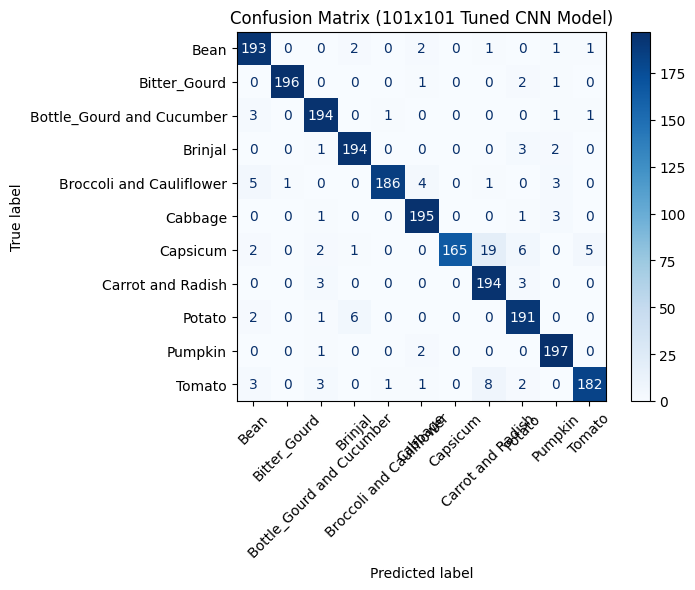

In [76]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_101:
  preds = tuned_101_model.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (101x101 Tuned CNN Model)")
plt.show()

In [77]:
# Evaluate the best model
test_loss, test_acc = tuned_101_model.evaluate(test_101)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

69/69 [==============================] - 1s 17ms/step - loss: 0.1883 - accuracy: 0.9486
Test Accuracy: 0.9486
Test Loss: 0.1883


## Compare all the models

In [78]:
# Evaluate the base CNN model's Performance
def evaluate_model_basic(model, test_ds, model_name):
    print(f"\nEvaluating {model_name}:")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1-accuracy):.4f}")
    return loss, accuracy

# Get metrics for comparison
loss_23, acc_23 = evaluate_model_basic(model_23, test_23, "23x23 Model")
loss_101, acc_101 = evaluate_model_basic(model_101, test_101, "101x101 Model")

print(f"\nAccuracy Improvement: {(acc_101-acc_23):.4f}")
print(f"Loss Reduction: {(loss_23-loss_101):.4f}")


Evaluating 23x23 Model:
Test Loss: 1.2631
Test Accuracy: 0.6759
Error Rate: 0.3241

Evaluating 101x101 Model:
Test Loss: 2.2382
Test Accuracy: 0.4991
Error Rate: 0.5009

Accuracy Improvement: -0.1768
Loss Reduction: -0.9750


In [79]:
# Evaluate the improved model's performance
def evaluate_model_basic_improved(model, test_ds, model_name):
    print(f"\nEvaluating {model_name} (Improved):")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1 - accuracy):.4f}")
    return loss, accuracy

# Evaluate improved models
loss_23_improved, acc_23_improved = evaluate_model_basic_improved(improved_model_23, test_23, "23x23 Model")
loss_101_improved, acc_101_improved = evaluate_model_basic_improved(improved_model_101, test_101, "101x101 Model")

# Comparison between improved models
print(f"\nAccuracy Improvement (101x101 - 23x23): {(acc_101_improved - acc_23_improved):.4f}")
print(f"Loss Reduction (23x23 - 101x101): {(loss_23_improved - loss_101_improved):.4f}")


Evaluating 23x23 Model (Improved):
Test Loss: 0.6927
Test Accuracy: 0.7732
Error Rate: 0.2268

Evaluating 101x101 Model (Improved):
Test Loss: 1.5868
Test Accuracy: 0.4077
Error Rate: 0.5923

Accuracy Improvement (101x101 - 23x23): -0.3655
Loss Reduction (23x23 - 101x101): -0.8942


In [80]:
# Evaluate the tuned model's performance
def evaluate_tuned_model(model, test_ds, model_name):
    print(f"\nEvaluating {model_name} (Tuned):")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1 - accuracy):.4f}")
    return loss, accuracy

# Evaluate tuned models
loss_23_tuned, acc_23_tuned = evaluate_tuned_model(tuned_23_model, test_23, "23x23 Model")
loss_101_tuned, acc_101_tuned = evaluate_tuned_model(tuned_101_model, test_101, "101x101 Model")

# Comparison between improved models
print(f"\nAccuracy Improvement (101x101 - 23x23): {(acc_101_improved - acc_23_improved):.4f}")
print(f"Loss Reduction (23x23 - 101x101): {(loss_23_improved - loss_101_improved):.4f}")


Evaluating 23x23 Model (Tuned):
Test Loss: 0.6464
Test Accuracy: 0.8232
Error Rate: 0.1768

Evaluating 101x101 Model (Tuned):
Test Loss: 0.1883
Test Accuracy: 0.9486
Error Rate: 0.0514

Accuracy Improvement (101x101 - 23x23): -0.3655
Loss Reduction (23x23 - 101x101): -0.8942
